# Imports

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, callbacks
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from termcolor import colored

# Load Coin Dataset

Set directories based on environment

In [19]:
# >>>> google colab <<<<
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = '/content/drive/MyDrive/coin_classifier/'

# >>>> local <<<<
base_dir = '.'


dataset_dir = '%s/images/obv_biased_images/' % base_dir
model_dir = '%s/saved_models/coin_classifier_obv_biased/' % base_dir
tflite_dir = '%s/saved_models/coin_classifier_obv_biased.tflite' % base_dir

Create training and validation data generators

In [20]:
batch_size = 128
img_dim = 256
img_shape = (img_dim, img_dim, 3)

labels = open('%s/labels/coin_classifier_labels_obv_biased.txt' % base_dir).readlines()
labels = list(map(lambda x: x.strip(), labels))
class_count = len(labels)

zoom_layer = layers.RandomZoom((0, 0.2))
zoom = lambda x: zoom_layer(x)

datagen = preprocessing.image.ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.1,
  height_shift_range=0.1,
  brightness_range=(0.6, 1.4),
  preprocessing_function=zoom,
  rescale=1./255,
  validation_split=0.4,
)

train_generator = datagen.flow_from_directory(
  dataset_dir,
  target_size=(img_dim, img_dim),
  batch_size=batch_size,
  interpolation='box',
  subset='training',
)
val_generator = datagen.flow_from_directory(
  dataset_dir,
  target_size=(img_dim, img_dim),
  batch_size=batch_size,
  interpolation='box',
  subset='validation',
)

Found 2487 images belonging to 48 classes.
Found 1621 images belonging to 48 classes.


Display coin images

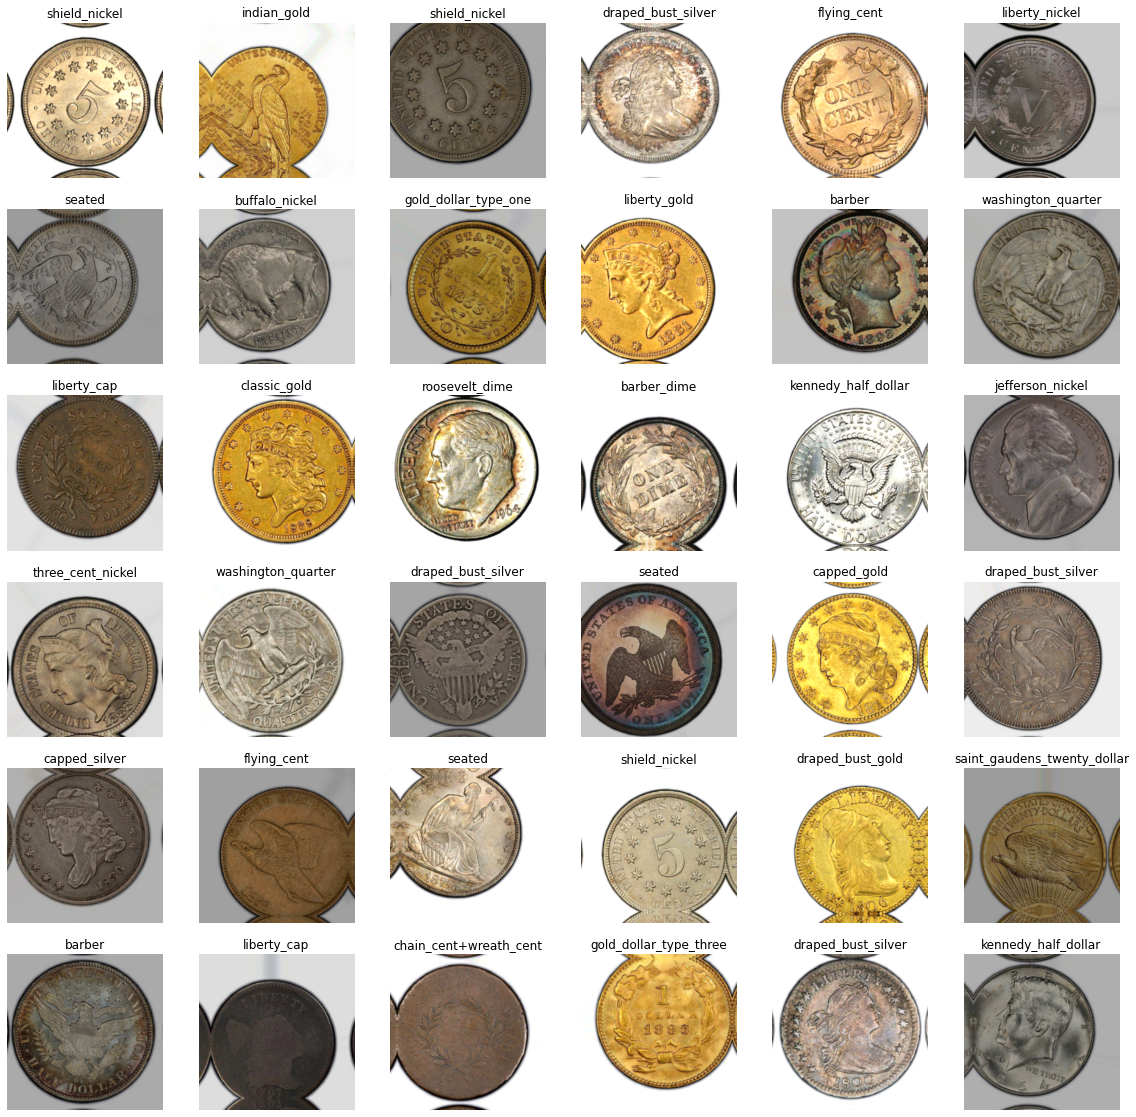

In [21]:
fig = plt.figure(figsize=(20, 20))
X_batch, y_batch = train_generator.next()
for i in range(min(len(X_batch), 36)):
  fig.add_subplot(6, 6, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[np.argmax(y_batch[i])])

# Create and Train CNN

In [22]:
coin_classifier = models.Sequential([
  layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=img_shape),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(class_count, activation='softmax'),
])
coin_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)      

In [23]:
coin_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', F1Score(class_count)])
history = coin_classifier.fit(
  train_generator,
  callbacks=[
    callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
    callbacks.ModelCheckpoint('checkpoint', monitor='val_accuracy', save_best_only=True),
  ],
  validation_data=val_generator,
  epochs=200,
)

Epoch 1/200
20/20 [==============================] - 132s 7s/step - loss: 3.6838 - accuracy: 0.1078 - f1_score: 0.0082 - val_loss: 3.5816 - val_accuracy: 0.1258 - val_f1_score: 0.0047
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/200
20/20 [==============================] - 126s 6s/step - loss: 3.5368 - accuracy: 0.1323 - f1_score: 0.0133 - val_loss: 3.3408 - val_accuracy: 0.1629 - val_f1_score: 0.0113
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/200
20/20 [==============================] - 127s 6s/step - loss: 3.2458 - accuracy: 0.1580 - f1_score: 0.0254 - val_loss: 3.1259 - val_accuracy: 0.1703 - val_f1_score: 0.0165
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/200
20/20 [==============================] - 126s 6s/step - loss: 3.1239 - accuracy: 0.1701 - f1_score: 0.0292 - val_loss: 2.9911 - val_accuracy: 0.1814 - val_f1_score: 0.0201
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 5/200
20/20 [==============================] -

In [26]:
coin_classifier = models.load_model('checkpoint')

Plot training and validation accuracies

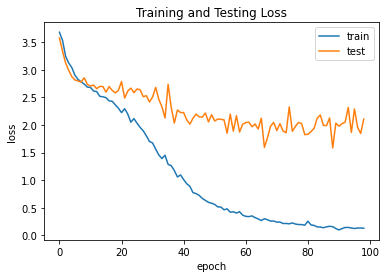

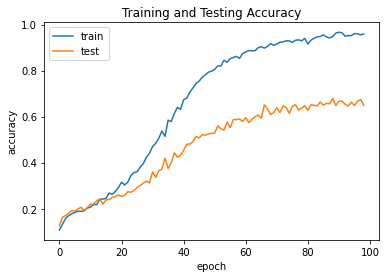

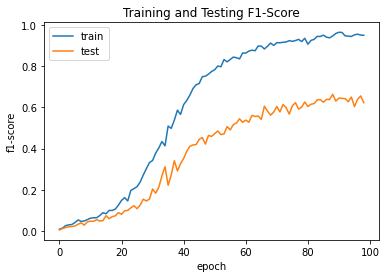

In [24]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Testing Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Testing Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

# f1 accuracy
plt.plot(np.mean(history.history['f1_score'], axis=1))
plt.plot(np.mean(history.history['val_f1_score'], axis=1))
plt.title('Training and Testing F1-Score')
plt.xlabel('epoch')
plt.ylabel('f1-score')
plt.legend(['train', 'test'])
plt.show()

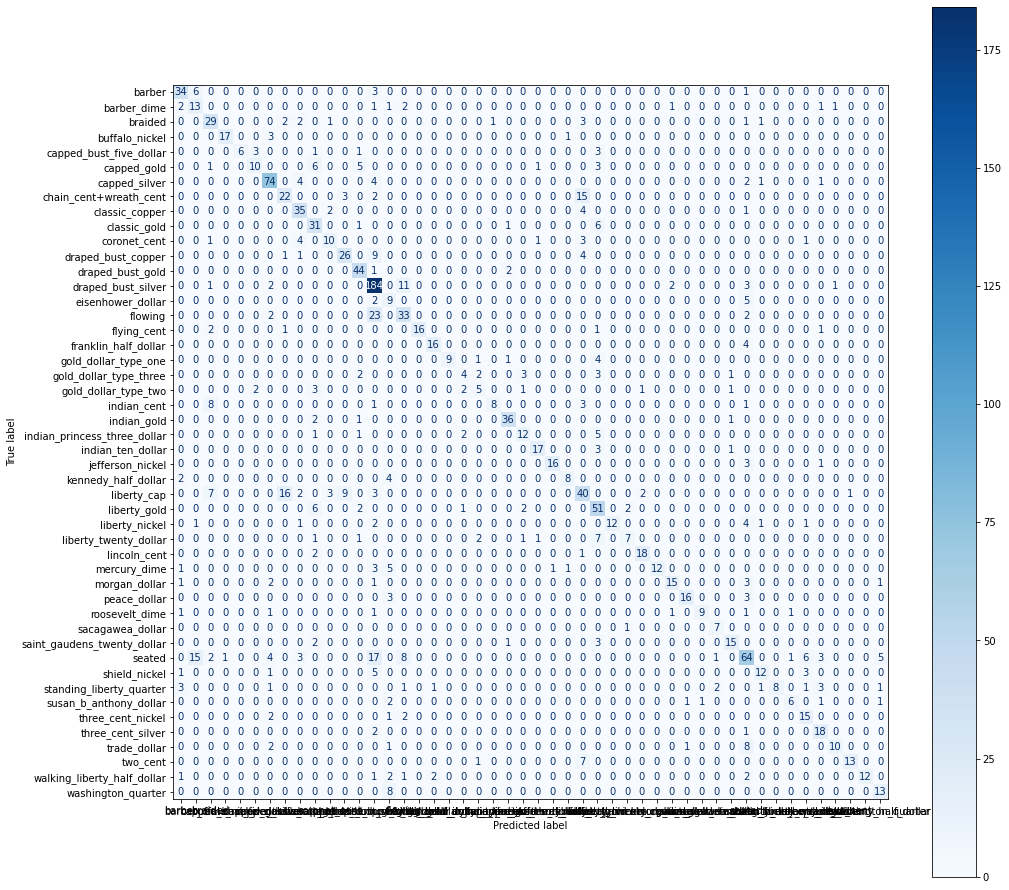

In [27]:
predictions, true = [], []
batches = [val_generator.next() for _ in range(len(val_generator))]
for X, y in batches:
  predictions += list(np.argmax(coin_classifier.predict(X), axis=1))
  true += list(np.argmax(y, axis=1))

fig, ax = plt.subplots(figsize=(16, 16))
cm = confusion_matrix(true, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(ax=ax, cmap='Blues')
plt.show()

# Save/Load Model:

Save model

In [28]:
coin_classifier.save(model_dir)

INFO:tensorflow:Assets written to: ./saved_models/coin_classifier_obv_biased/assets


Save model using tflite format

In [5]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()
with open(tflite_dir, 'wb') as f:
  f.write(tflite_model)

2021-12-16 20:13:22.673328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-12-16 20:13:22.673343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-12-16 20:13:22.673347: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2021-12-16 20:13:22.674142: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ./saved_models/coin_classifier_obv_biased/
2021-12-16 20:13:22.677514: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-12-16 20:13:22.677528: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ./saved_models/coin_classifier_obv_biased/
2021-12-16 20:13:22.690631: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2021-12-16 20:13:22.822739: I tensorflow/cc/saved_model/loader.cc:195] Running initialization o

Load model

In [11]:
coin_classifier = models.load_model(model_dir)

Load tflite model

In [6]:
interpreter = tf.lite.Interpreter(tflite_dir)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test Images:

Calculate class accuracies for validation set

In [29]:
from collections import Counter

correct = {}
total = {}
predictions = {}
for i in range(len(labels)):
  predictions[i] = Counter()
  correct[i] = 0
  total[i] = 0

batches = [val_generator.next() for _ in range(len(val_generator))]

for X, y in batches:
  preds = [np.argmax(pred) for pred in coin_classifier.predict(X)]
  for i, pred in enumerate(preds):
    true = np.argmax(y[i])
    predictions[true][pred] += 1
    if true == pred:
      correct[true] += 1
    total[true] += 1

In [30]:
running_count = 0
running_total = 0
for label, count in sorted(correct.items(), key=lambda x: x[1] / total[x[0]], reverse=True):
  accuracy = count / total[label]
  running_count += count
  running_total += total[label]
  pred_list = sorted(list(predictions[label].items()), key=lambda x: x[1], reverse=True)
  pred_list = [(labels[pred[0]], pred[1]) for pred in pred_list]
  print('==== %s ====' % labels[label])
  print('Accuracy: %.2f%%' % (accuracy * 100))
  print(pred_list)
  print()
print('Overall Accuracy: %.2f%%' % ((running_count / running_total) * 100))

==== indian_gold ====
Accuracy: 95.00%
[('indian_gold', 38), ('classic_gold', 1), ('capped_gold', 1)]

==== draped_bust_gold ====
Accuracy: 93.62%
[('draped_bust_gold', 44), ('draped_bust_silver', 1), ('capped_gold', 1), ('liberty_gold', 1)]

==== draped_bust_silver ====
Accuracy: 88.24%
[('draped_bust_silver', 180), ('flowing', 13), ('morgan_dollar', 3), ('seated', 3), ('barber', 2), ('chain_cent+wreath_cent', 1), ('capped_silver', 1), ('eisenhower_dollar', 1)]

==== three_cent_silver ====
Accuracy: 85.71%
[('three_cent_silver', 18), ('seated', 2), ('draped_bust_silver', 1)]

==== jefferson_nickel ====
Accuracy: 85.00%
[('jefferson_nickel', 17), ('seated', 3)]

==== capped_silver ====
Accuracy: 84.88%
[('capped_silver', 73), ('classic_copper', 6), ('seated', 4), ('draped_bust_silver', 2), ('three_cent_silver', 1)]

==== susan_b_anthony_dollar ====
Accuracy: 83.33%
[('susan_b_anthony_dollar', 10), ('capped_silver', 1), ('peace_dollar', 1)]

==== buffalo_nickel ====
Accuracy: 80.95%
[('

Test custom images

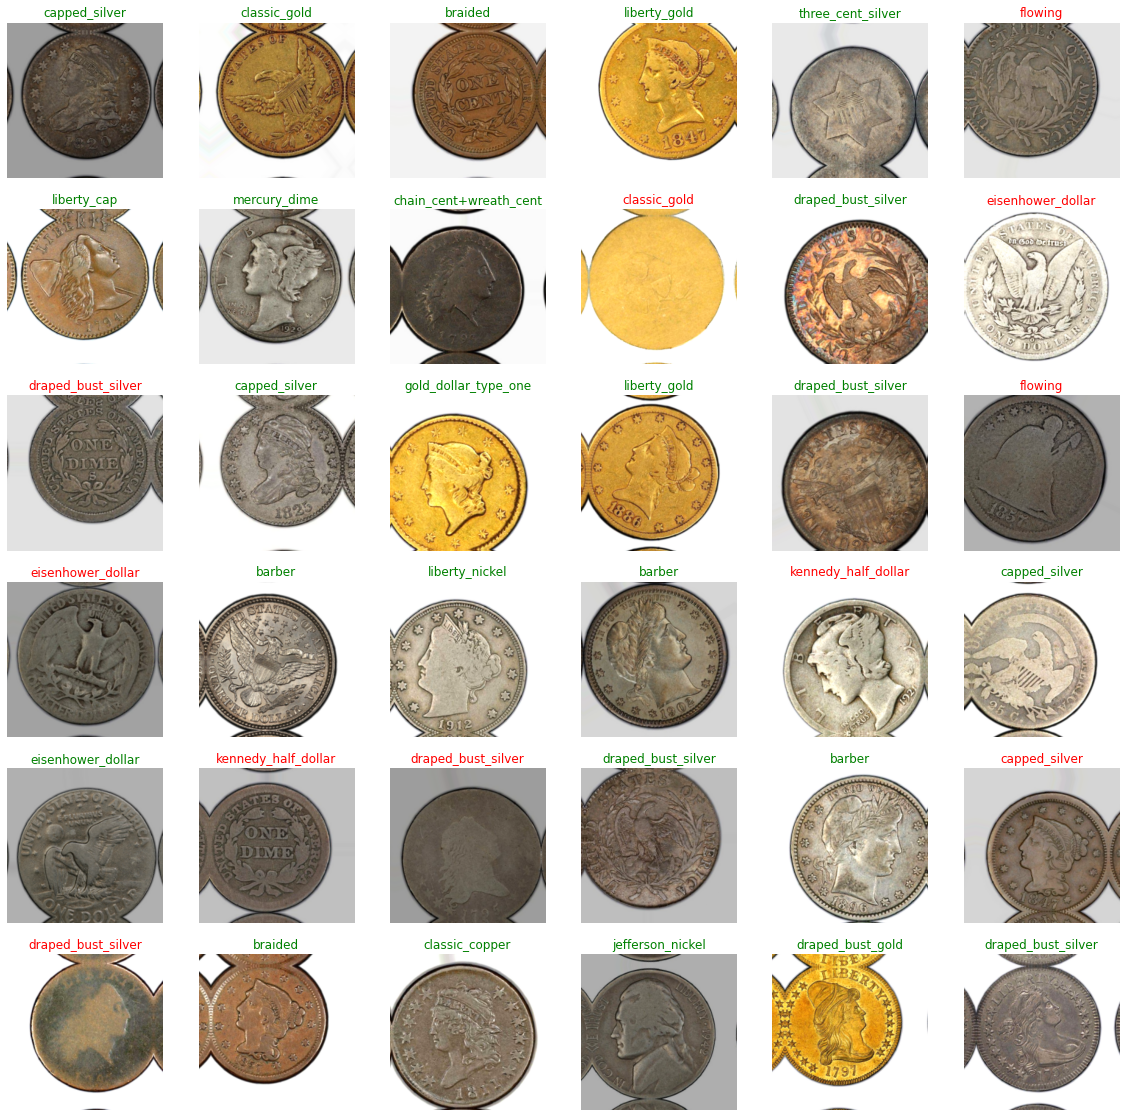

In [31]:
fig = plt.figure(figsize=(20, 20))
X_batch, y_batch = val_generator.next()
predictions = coin_classifier.predict(X_batch)
for i in range(min(len(X_batch), 36)):
  fig.add_subplot(6, 6, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  title_obj = plt.title(labels[np.argmax(predictions[i])])
  plt.setp(title_obj, color='g' if np.argmax(predictions[i]) == np.argmax(y_batch[i]) else 'r')

In [32]:
def load_img(img_name):
  img = Image.open('%s/images/test_images/%s' % (base_dir, img_name))
  img = img.resize(size=(img_dim, img_dim))
  img_data = np.divide(preprocessing.image.img_to_array(img), 255.0)
  return img_data, img_name.split('-')[0]

def predict(img_data, using_tflite=False):
  if using_tflite:
    interpreter.set_tensor(input_details[0]['index'], [img_data])
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])[0]
  else:
    return coin_classifier.predict(tf.data.Dataset.from_tensors([img_data]))[0]

def get_color(prediction, true, index):
  if index == -1:
    return 'green' if prediction == true else 'red'
  else:
    return 'yellow' if prediction == true else 'white'

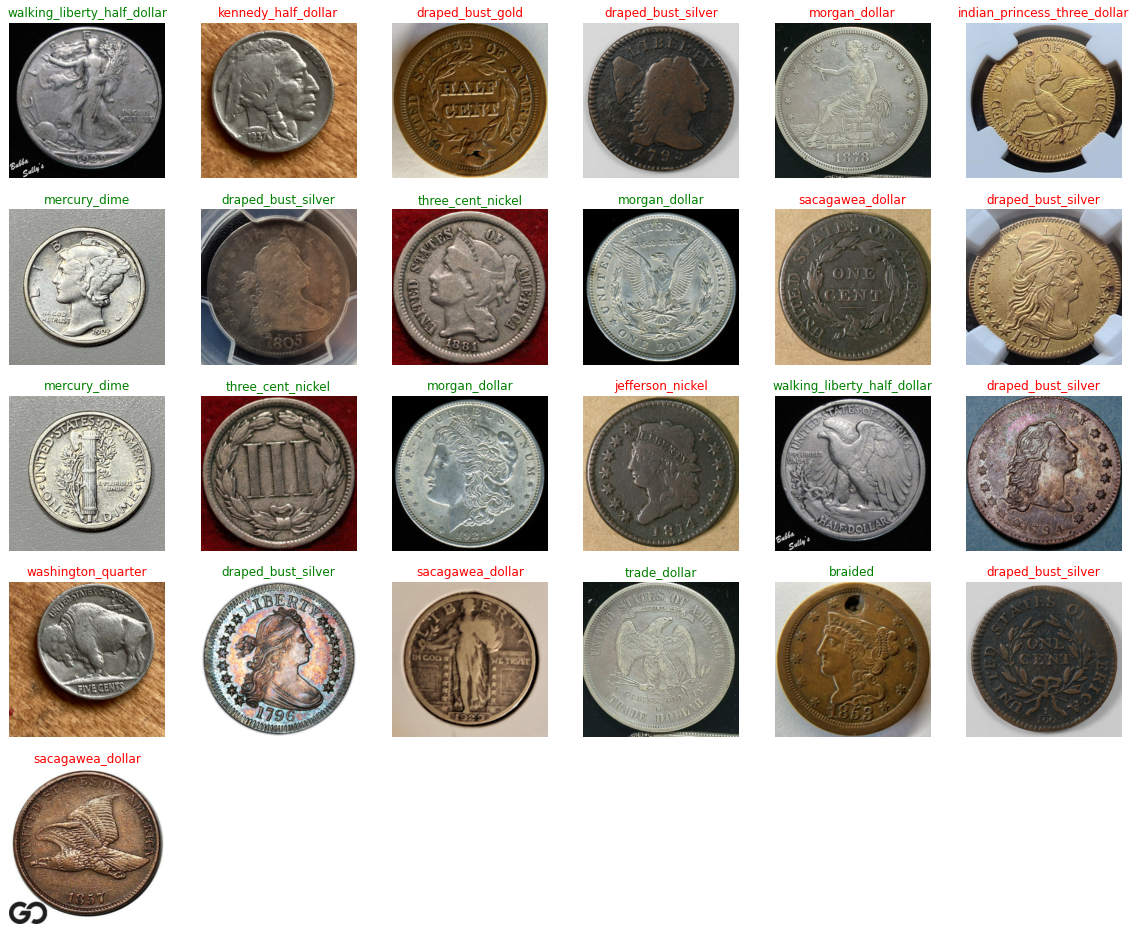

In [33]:
fig = plt.figure(figsize=(20, 20))
images = [load_img(img) for img in os.listdir('%s/images/test_images/' % base_dir)]
X = np.array([img[0] for img in images])
y = np.array([img[1] for img in images])
predictions = coin_classifier.predict(X)
for i in range(min(len(X), 36)):
  fig.add_subplot(6, 6, i + 1)
  plt.imshow(X[i])
  plt.axis('off')
  title_obj = plt.title(labels[np.argmax(predictions[i])])
  plt.setp(title_obj, color='g' if labels[np.argmax(predictions[i])] == y[i] else 'r')

1: 99.95% morgan_dollar
2: 0.05% barber
3: 0.00% peace_dollar
4: 0.00% draped_bust_silver
5: 0.00% liberty_nickel


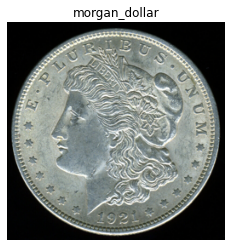

In [34]:
img_data, label = load_img('morgan_dollar-o.jpg')
prediction = predict(img_data)
ranked = np.argsort(prediction)

prediction_sorted = sorted(prediction)

for i in range(-1,-6,-1):
  print(colored('%d: %.2f%% %s' % (abs(i), prediction_sorted[i] * 100, labels[ranked[i]]), get_color(labels[ranked[i]], label, i)))

plt.title(labels[np.argmax(prediction)])
plt.axis('off')
plt.imshow(img_data)